In [1]:
import numpy as np
import matplotlib.pylab as plt
from glob import glob
from PIL import Image
import torch 
from torch.autograd import Variable
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

In [4]:
# Rutas de los archivos
train_files = glob('mnist/train/*/*.png')
valid_files = glob('mnist/valid/*/*.png')
test_files = glob('mnist/test/*/*.png')

print('Primer ruta es: ',train_files[0])

# Se vueleven aleatorios los archivos
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

print('Las longitudes son: train {}, valid {}, test {}'.format(len(train_files), len(valid_files), len(test_files)))

# Se cargan las imagenes en las listas
# Datos de entrenamiento
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
    Y_train.append(int(train_file.split('/')[2]))
    X_train.append(np.array(Image.open(train_file)))

# Datos de validación 
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
    Y_valid.append(int(valid_file.split('/')[2]))
    X_valid.append(np.array(Image.open(valid_file)))

# Datos de prueba
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
    Y_test.append(int(test_file.split('/')[2]))
    X_test.append(np.array(Image.open(test_file)))

print('Verificamos las longitudes: Tr {}, V {}, Te {}'.format(len(X_train), len(X_valid), len(X_test)))

def tensor (X,Y):
    X = Variable(torch.from_numpy(np.array(X))).float()
    Y = Variable(torch.from_numpy(np.array(Y))).long()
    return X,Y

def entrena(X_train,Y_train,X_valid,Y_valid,X_test, Y_test,model, ne, optimizer, criterion):
    # Listas de evaluacion del entrenamiento
    loss_train = []
    f1_train = []
    acc_train = []

    # Listas de evaluacion de la validacion
    loss_valid = []
    f1_valid = []
    acc_valid = []

    total_it = 0

    # Se entrena la red
    for epoch in range(ne):
        model.train()

        Xtr = X_train.view(X_train.size(0), -1)
        Y_pred = model(Xtr)

        loss = criterion(Y_pred,Y_train)
        loss_train.append(loss.item())

        Y_pred = torch.argmax(Y_pred, 1)
        f1_train.append( f1_score(Y_train,Y_pred, average='macro') )

        acc = sum(Y_train == Y_pred)/len(Y_pred)
        acc_train.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        Xvl = X_valid.view(X_valid.size(0), -1)
        Y_pred = model(Xvl)  
        loss = criterion(Y_pred,Y_valid)
        loss_valid.append(loss.item())

        Y_pred = torch.argmax(Y_pred, 1)
        f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

        acc = sum(Y_valid == Y_pred)/len(Y_pred)
        acc_valid.append(acc)

    CM(Y_valid, Y_pred, 10)
    
    return loss_valid[-1], f1_valid[-1], acc_valid[-1]

def modelo1(input_dim,out_dim,hidden):
    model = torch.nn.Sequential(
        torch.nn.Linear(input_dim, hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden, out_dim)
    )
    return model

def modelo2(input_dim,out_dim,hidden):
    model = torch.nn.Sequential(
        torch.nn.Linear(input_dim, hidden),
        torch.nn.Tanh(),
        torch.nn.Linear(hidden, hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden, hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden, out_dim)
    )
    return model
    

def red(X_train,Y_train,X_valid,Y_valid,X_test, Y_test,n_epoch,batch_size,learning_rate,weight_decay,hd_list,modelo,values,pbar,final):
    
    for ne in n_epoch:
        for bs in batch_size:
            train_ds = TensorDataset(X_train, Y_train)
            train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

            for lr in learning_rate:
                for wd in weight_decay:
                    for hd in hd_list:
                        
                        print('*')
                        print('Esta cargando para {} epocas, {} hd, {} Weight Decay, {} Batch Size y {} Learning Rate.'.format(ne,hd,wd,bs,lr))
                        print('')
                        
                        # Dimensiones de la red neuronal
                        input_dim = 28*28
                        out_dim = 10
                        hidden = hd

                        # Se hace el modelo con las dimensiones anteriores
                        model = modelo(input_dim,out_dim,hidden)
                        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                        criterion = torch.nn.CrossEntropyLoss()
                        
                        loss,f1,acc=entrena(X_train,Y_train,X_valid,Y_valid,X_test, Y_test,model,ne,optimizer,criterion)
                        
                        values['ne{}, hd{}, wd{}, bs{}, lr{}'.format(ne,hd,wd,bs,lr)]={'loss':loss,'f1':f1,'acc':acc}
                        print('')
                        print('')
                        print('Con {} epocas, {} hd, {} Weight Decay, {} Batch Size y {} Learning Rate se tiene: loss: {}, f1: {}, acc: {}'.format(ne,hd,wd,bs,lr,loss,f1,acc))
                
                        pbar.update()
    pbar.close()
    
    
    
def CM(Y_true, Y_pred, classes):
    fig = plt.figure(figsize=(10, 10))
    cm = confusion_matrix(Y_true, Y_pred)
    lclasses = np.arange(0,classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmap=plt.cm.Blues
    ax = fig.add_subplot(1,1,1)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
    ax.set_xlabel("Predicted",size=20)
    ax.set_ylabel("True",size=20)
    ax.set_ylim(classes-0.5, -0.5)

    plt.setp(ax.get_xticklabels(), size=12)
    plt.setp(ax.get_yticklabels(), size=12)

    fmt = '.2f'
    thresh = cm.max()/2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

    plt.show()


def metodo (n_epoch,lr,weight,batch,hd_list):
    X_train_p, Y_train_p = tensor(X_train, Y_train)
    X_valid_p, Y_valid_p = tensor(X_valid, Y_valid)
    X_test_p, Y_test_p = tensor(X_test, Y_test)
    
    modelo = [modelo1,modelo2]
    
    final = []
    for m in range(len(modelo)):
        pbar = tqdm(total=len(batch)*len(lr)*len(weight)*len(hd_list)*len(n_epoch))
        values = {}
        print('*')
        print('*')
        print('Utilizando el modelo {}'.format(m+1))
        print('*')
        red(X_train_p,Y_train_p,X_valid_p,Y_valid_p,X_test_p,Y_test_p,n_epoch,batch,lr,weight,hd_list,modelo[m],values,pbar,final)
        print('*')
        print('*')
        print('*')
        print('El orden de menor a mayor de los parametros es:')
        print('*')
        print('Para la perdida:')
        loss = dict(sorted(values.items(), key=lambda k_v: k_v[1]["loss"]))
        loss1 = list(loss.items())
        print(loss)
        print('*')
        print('Para el f1:')
        f1 = dict(sorted(values.items(), key=lambda k_v: k_v[1]["f1"],reverse=True))
        f11 = list(f1.items())
        print(f1)
        print('*')
        print('Para la acc:')
        acc = dict(sorted(values.items(), key=lambda k_v: k_v[1]["acc"],reverse=True))
        acc1 = list(acc.items())
        print(acc)
        final.append({'loss':loss1[0],'f1':f11[0],'acc':acc1[0]})
    print('*')
    print(final)
    return final
    
    

Primer ruta es:  mnist/train/9/4968.png
Las longitudes son: train 6000, valid 2000, test 992
Verificamos las longitudes: Tr 6000, V 2000, Te 992


  0%|          | 0/32 [00:00<?, ?it/s]

*
*
Utilizando el modelo 1
*
*
Esta cargando para 50 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



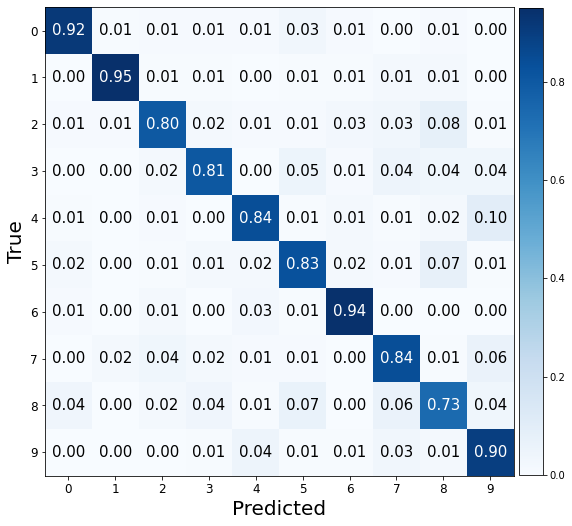



Con 50 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 0.6993809938430786, f1: 0.8554237729102901, acc: 0.8554999828338623
*
Esta cargando para 50 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



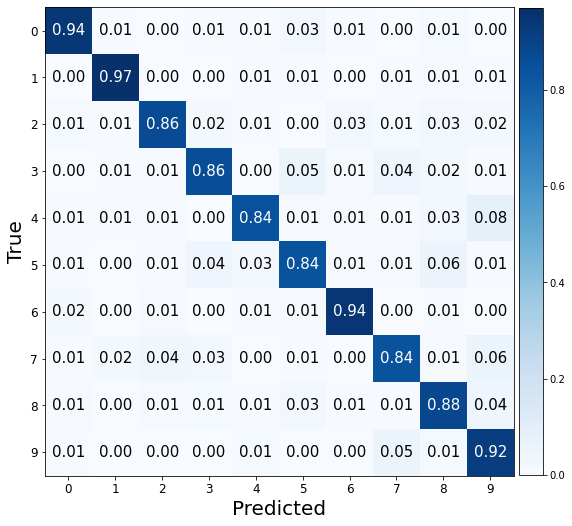



Con 50 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 1.0088589191436768, f1: 0.8900880389788641, acc: 0.8899999856948853
*
Esta cargando para 50 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



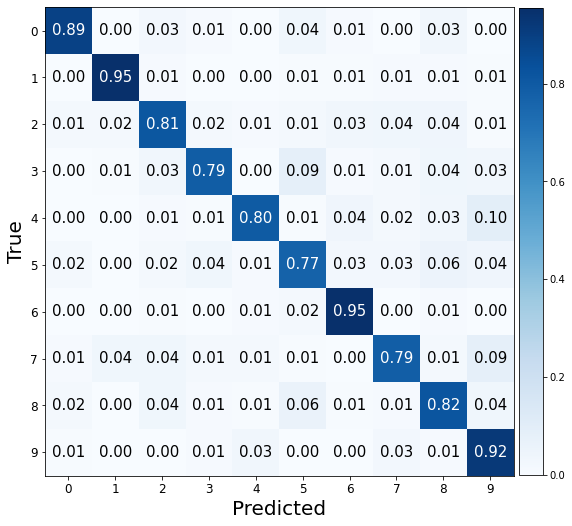



Con 50 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 0.7217832803726196, f1: 0.8488615938018288, acc: 0.8489999771118164
*
Esta cargando para 50 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



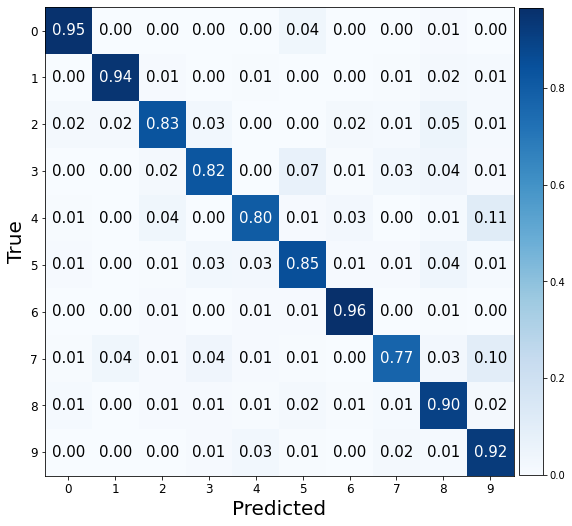



Con 50 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 0.7830874919891357, f1: 0.8758370222687238, acc: 0.8759999871253967
*
Esta cargando para 50 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



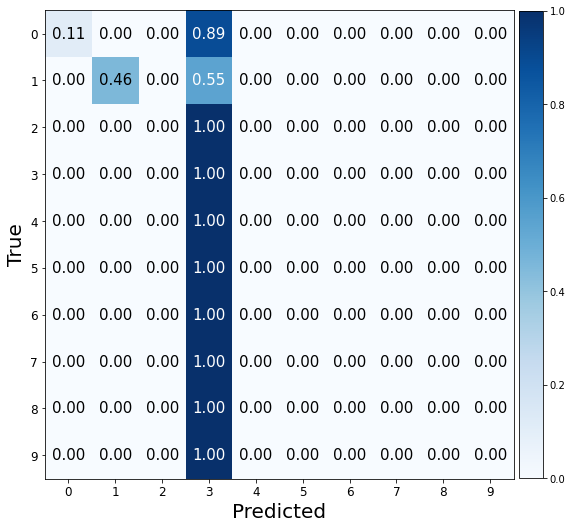



Con 50 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 2.1640195846557617, f1: 0.10152904251571011, acc: 0.15649999678134918
*
Esta cargando para 50 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



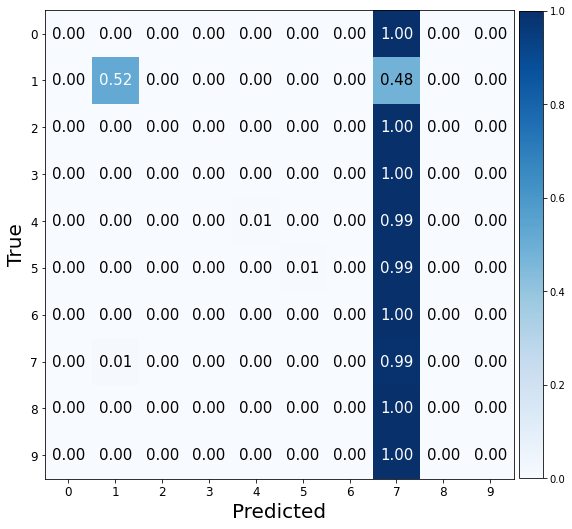



Con 50 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 3.7195146083831787, f1: 0.08889316026249736, acc: 0.15199999511241913
*
Esta cargando para 50 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



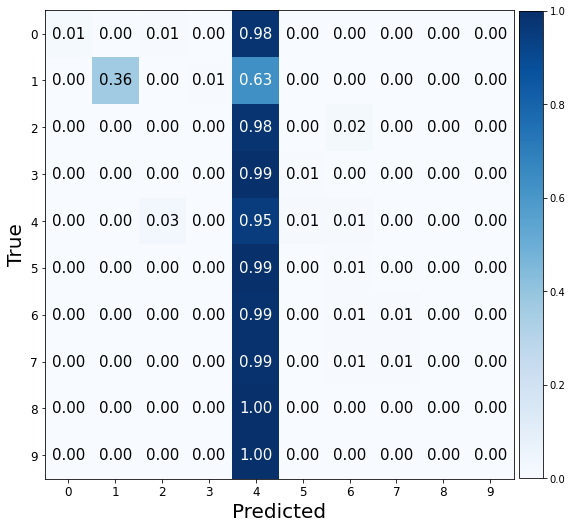



Con 50 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 2.2570652961730957, f1: 0.07646057624587335, acc: 0.1340000033378601
*
Esta cargando para 50 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



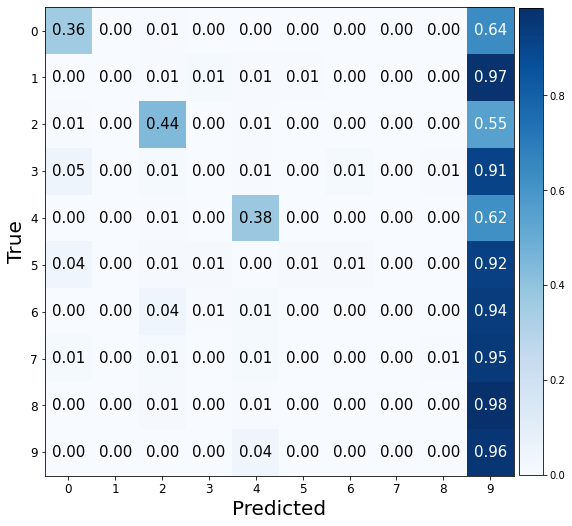



Con 50 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 2.2084925174713135, f1: 0.17926852951025435, acc: 0.21449999511241913
*
Esta cargando para 50 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



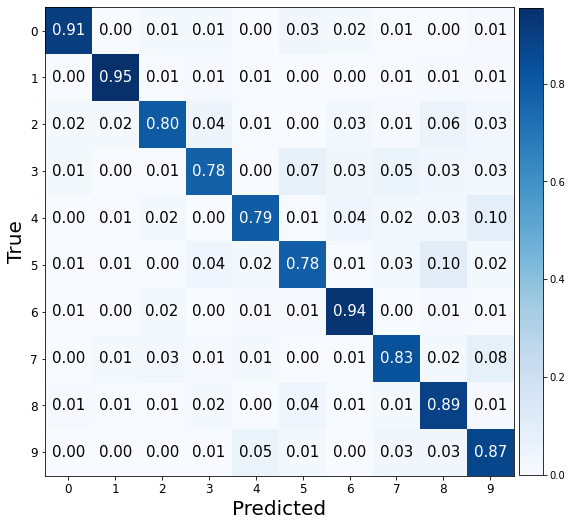



Con 50 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 0.9037847518920898, f1: 0.8530384674563265, acc: 0.8529999852180481
*
Esta cargando para 50 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



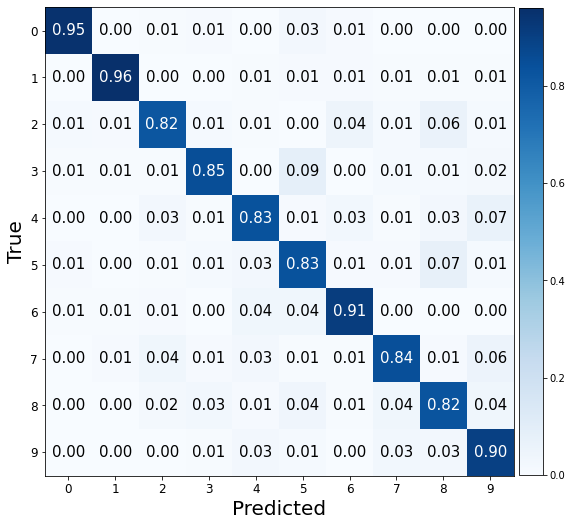



Con 50 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 0.9237285852432251, f1: 0.873370648703218, acc: 0.8730000257492065
*
Esta cargando para 50 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



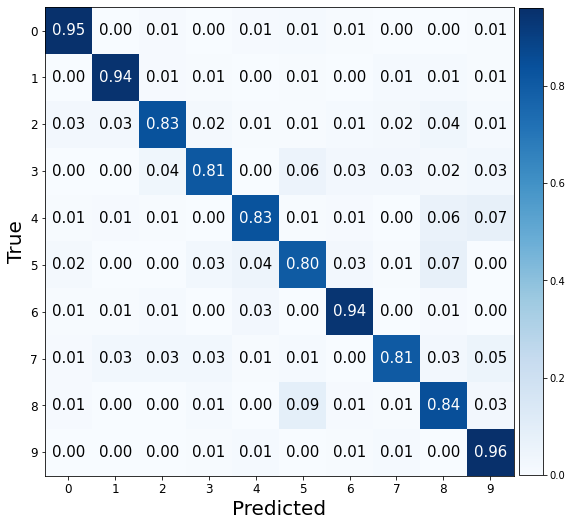



Con 50 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 0.7046553492546082, f1: 0.8720603304537118, acc: 0.8725000023841858
*
Esta cargando para 50 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



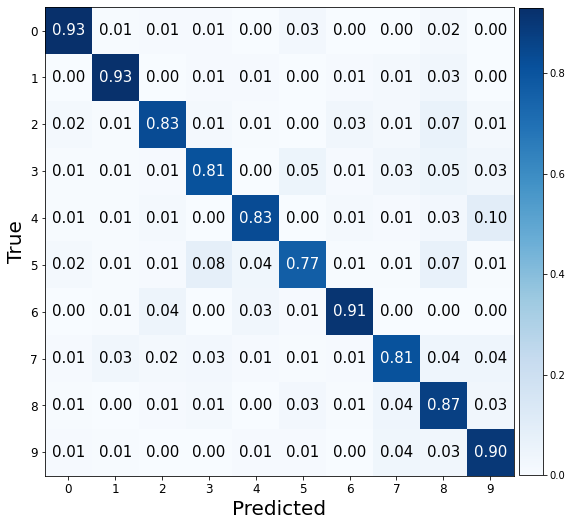



Con 50 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 0.7361355423927307, f1: 0.8583450242571523, acc: 0.8579999804496765
*
Esta cargando para 50 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



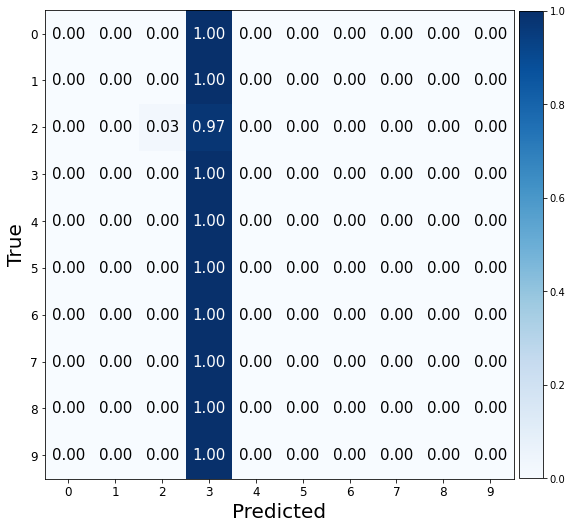



Con 50 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 2.2970805168151855, f1: 0.02310128340463359, acc: 0.10249999910593033
*
Esta cargando para 50 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



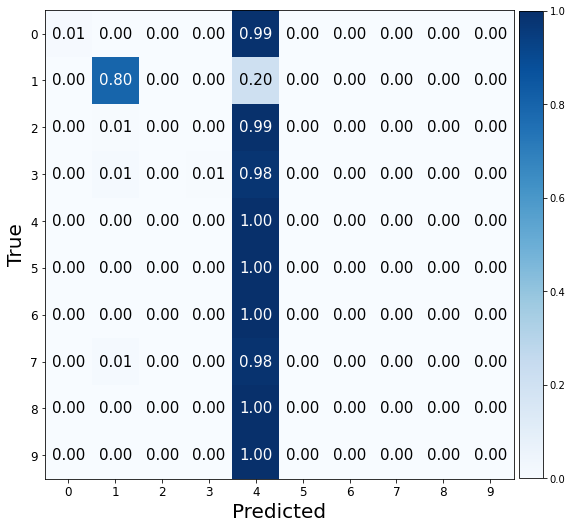



Con 50 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 3.271164655685425, f1: 0.10955520045634437, acc: 0.1809999942779541
*
Esta cargando para 50 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



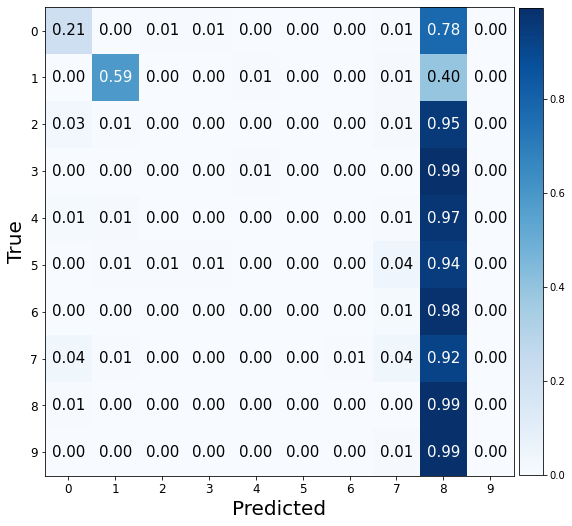



Con 50 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 2.3035964965820312, f1: 0.13174251601154846, acc: 0.18299999833106995
*
Esta cargando para 50 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



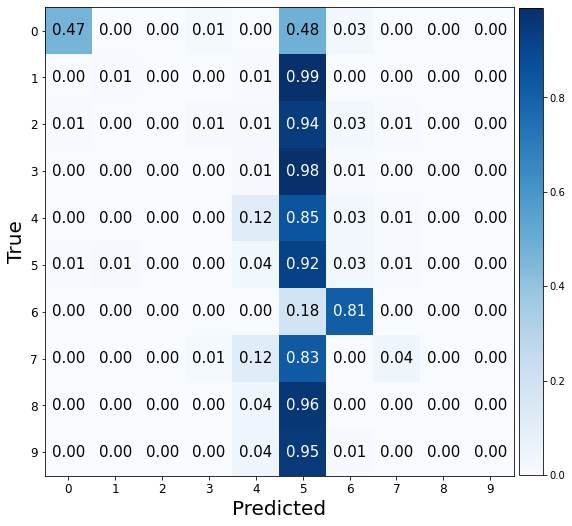



Con 50 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 2.336303234100342, f1: 0.19290551809101295, acc: 0.23649999499320984
*
Esta cargando para 150 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



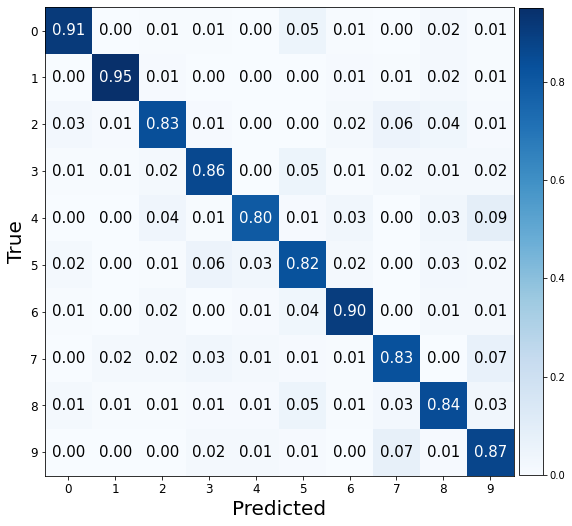



Con 150 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 0.7844319939613342, f1: 0.8624554137331778, acc: 0.8619999885559082
*
Esta cargando para 150 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



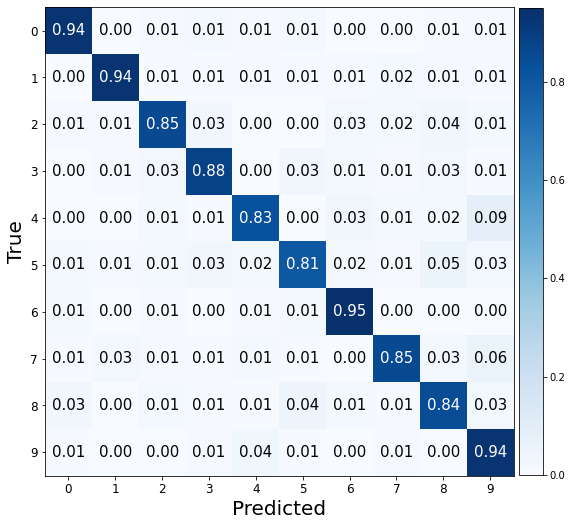



Con 150 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 0.6845663189888, f1: 0.8817660407075542, acc: 0.8820000290870667
*
Esta cargando para 150 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



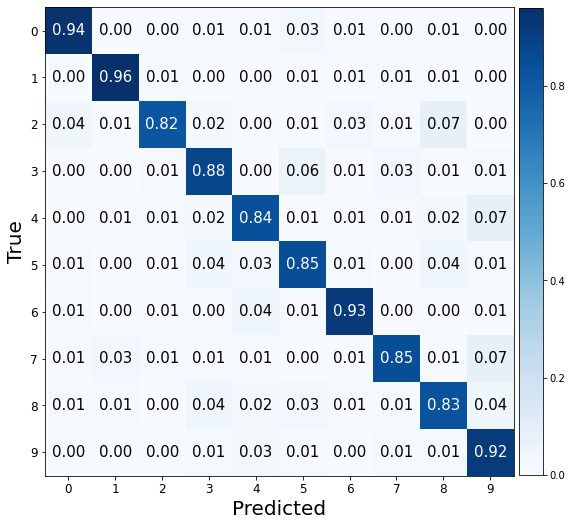



Con 150 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 0.6255832314491272, f1: 0.8809544618935311, acc: 0.8809999823570251
*
Esta cargando para 150 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



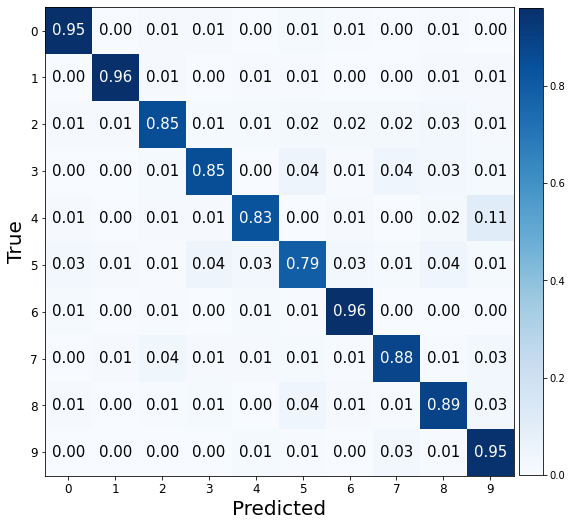



Con 150 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 0.5775547027587891, f1: 0.8905909311756168, acc: 0.890999972820282
*
Esta cargando para 150 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



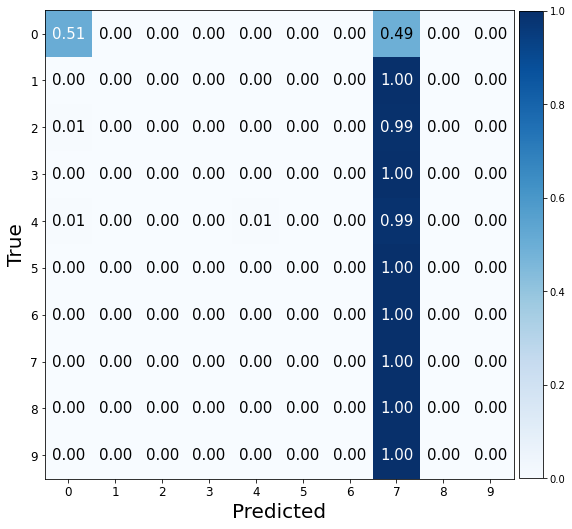



Con 150 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 3.33508038520813, f1: 0.08674566100793742, acc: 0.1509999930858612
*
Esta cargando para 150 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



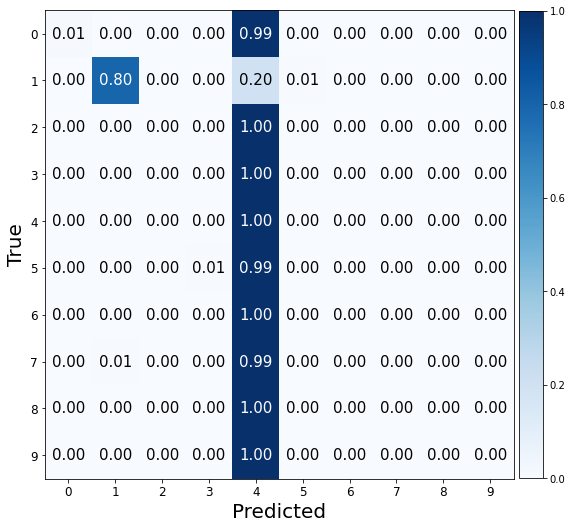



Con 150 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 2.3163247108459473, f1: 0.10995989677553217, acc: 0.18050000071525574
*
Esta cargando para 150 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



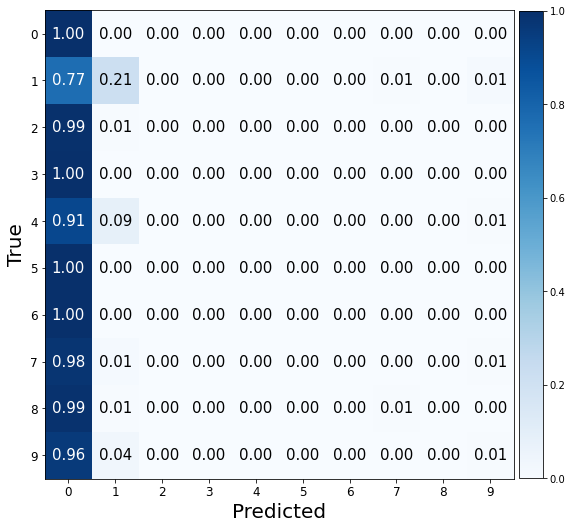



Con 150 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 151.91448974609375, f1: 0.05145644537353319, acc: 0.12200000137090683
*
Esta cargando para 150 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



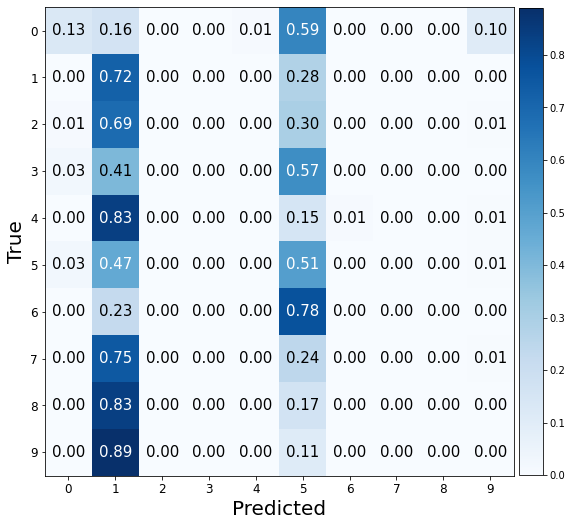



Con 150 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 5.721705913543701, f1: 0.06402095787274623, acc: 0.1354999989271164
*
Esta cargando para 150 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



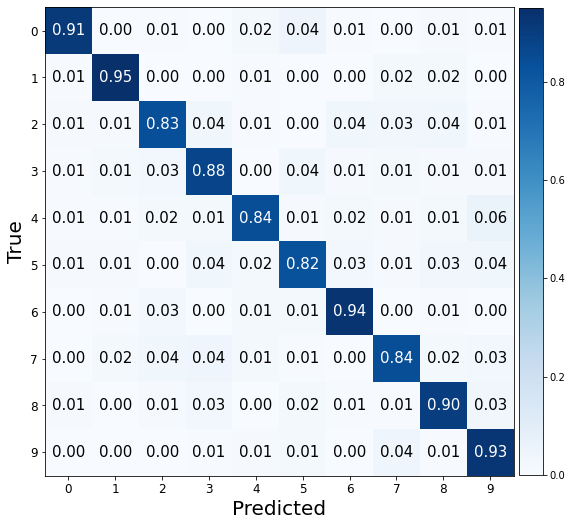



Con 150 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 0.6579856276512146, f1: 0.8828264331813678, acc: 0.8830000162124634
*
Esta cargando para 150 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



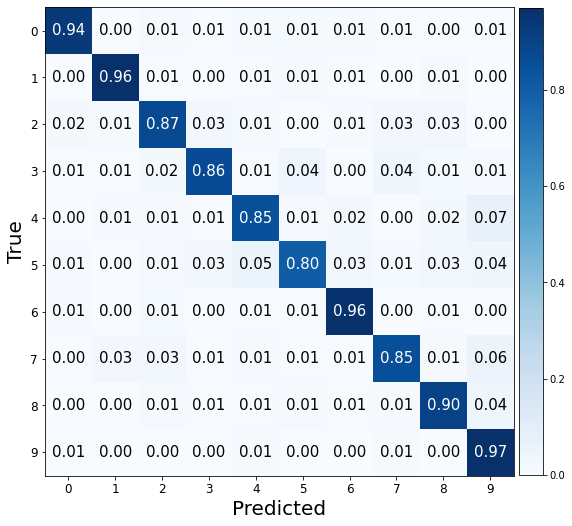



Con 150 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 0.6191997528076172, f1: 0.8966204423803849, acc: 0.8970000147819519
*
Esta cargando para 150 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



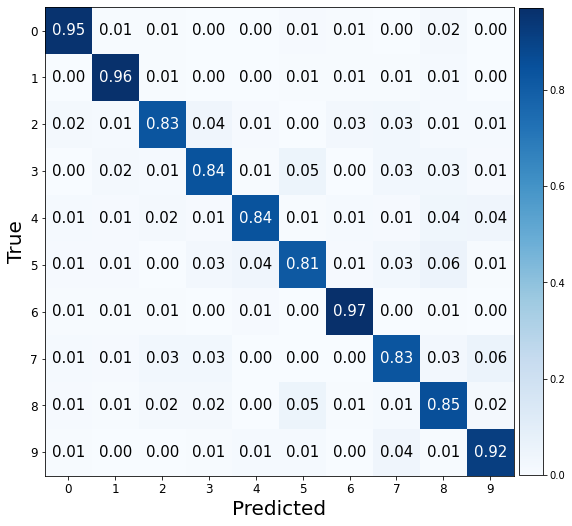



Con 150 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 0.6166930794715881, f1: 0.880991660294401, acc: 0.8815000057220459
*
Esta cargando para 150 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



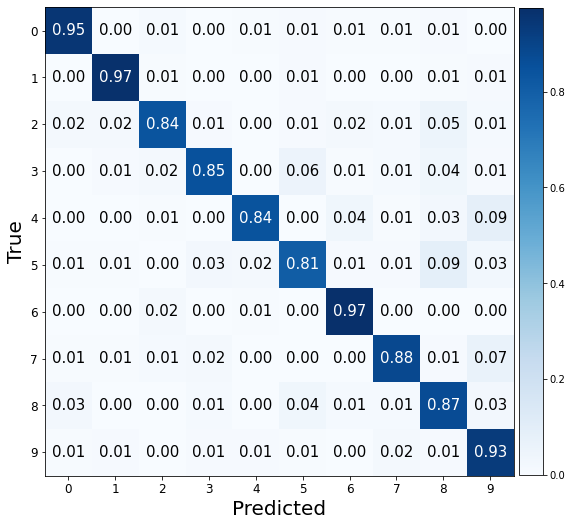



Con 150 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 0.5131293535232544, f1: 0.8915977712492202, acc: 0.8914999961853027
*
Esta cargando para 150 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



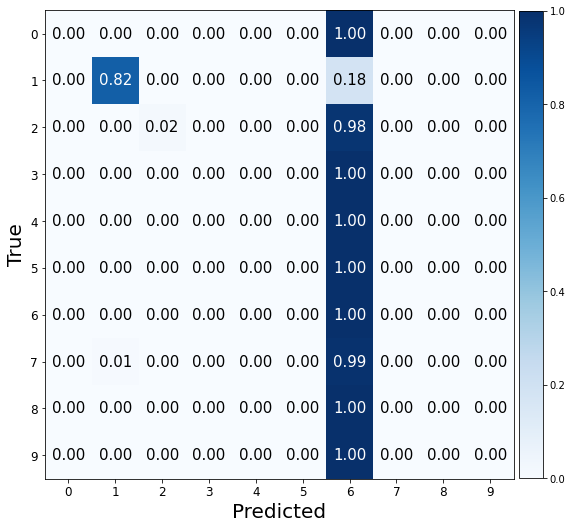



Con 150 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 2.6880667209625244, f1: 0.11324348846378574, acc: 0.18400000035762787
*
Esta cargando para 150 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



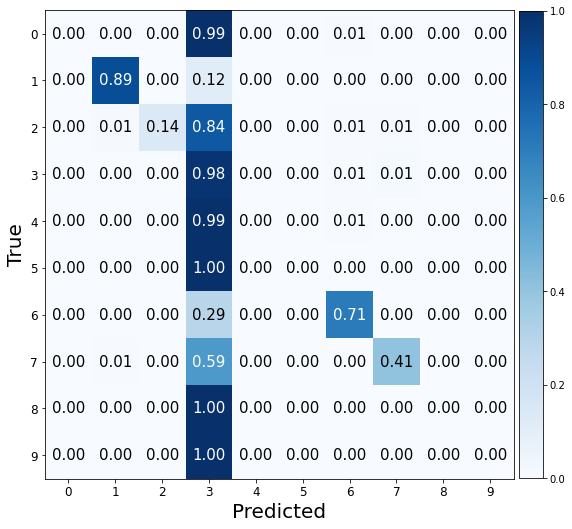



Con 150 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 4.683449745178223, f1: 0.2789024078645472, acc: 0.31200000643730164
*
Esta cargando para 150 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



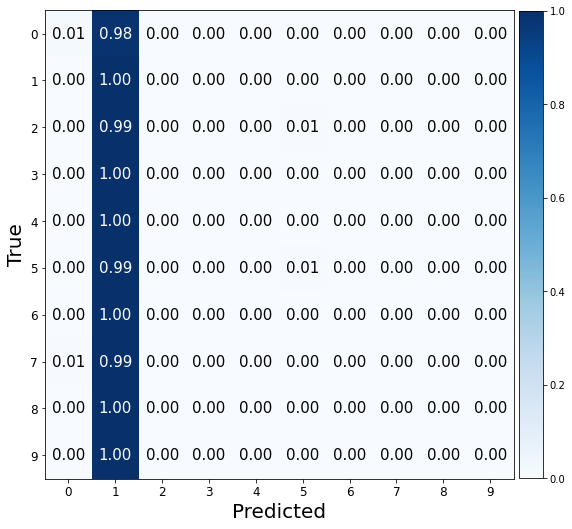



Con 150 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 2.307035446166992, f1: 0.022162816045666986, acc: 0.10199999809265137
*
Esta cargando para 150 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



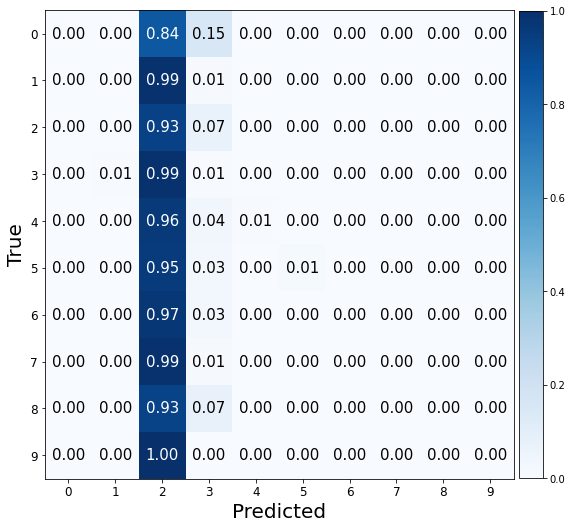



Con 150 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 2.6174490451812744, f1: 0.022276895356581117, acc: 0.09549999982118607
*
*
*
El orden de menor a mayor de los parametros es:
*
Para la perdida:
{'ne150, hd100, wd0.1, bs1024, lr0.001': {'loss': 0.5131293535232544, 'f1': 0.8915977712492202, 'acc': tensor(0.8915)}, 'ne150, hd100, wd0.1, bs256, lr0.001': {'loss': 0.5775547027587891, 'f1': 0.8905909311756168, 'acc': tensor(0.8910)}, 'ne150, hd80, wd0.1, bs1024, lr0.001': {'loss': 0.6166930794715881, 'f1': 0.880991660294401, 'acc': tensor(0.8815)}, 'ne150, hd100, wd0.001, bs1024, lr0.001': {'loss': 0.6191997528076172, 'f1': 0.8966204423803849, 'acc': tensor(0.8970)}, 'ne150, hd80, wd0.1, bs256, lr0.001': {'loss': 0.6255832314491272, 'f1': 0.8809544618935311, 'acc': tensor(0.8810)}, 'ne150, hd80, wd0.001, bs1024, lr0.001': {'loss': 0.6579856276512146, 'f1': 0.8828264331813678, 'acc': tensor(0.8830)}, 'ne150, hd100, wd0.001, bs256, lr0.001': {'loss

  0%|          | 0/32 [00:00<?, ?it/s]

*
*
Utilizando el modelo 2
*
*
Esta cargando para 50 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



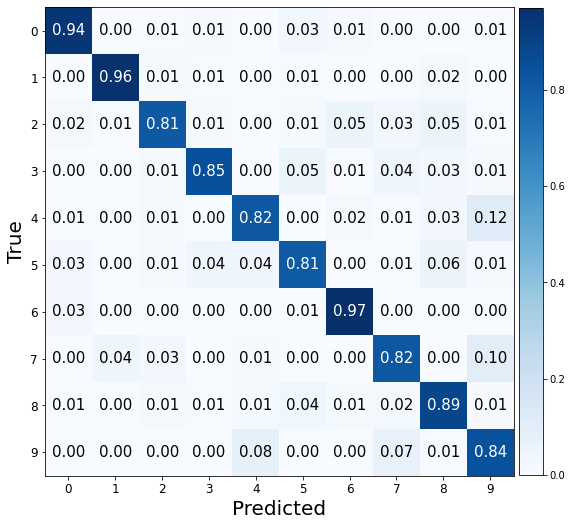



Con 50 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 0.4130142629146576, f1: 0.8723284222737149, acc: 0.8725000023841858
*
Esta cargando para 50 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



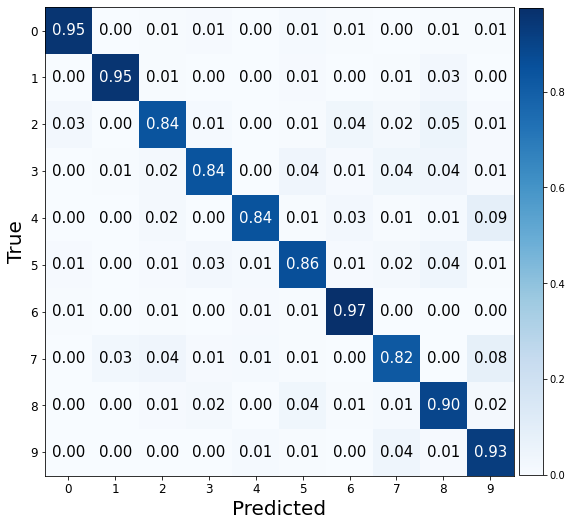



Con 50 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 0.35250672698020935, f1: 0.8909414637894004, acc: 0.890999972820282
*
Esta cargando para 50 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



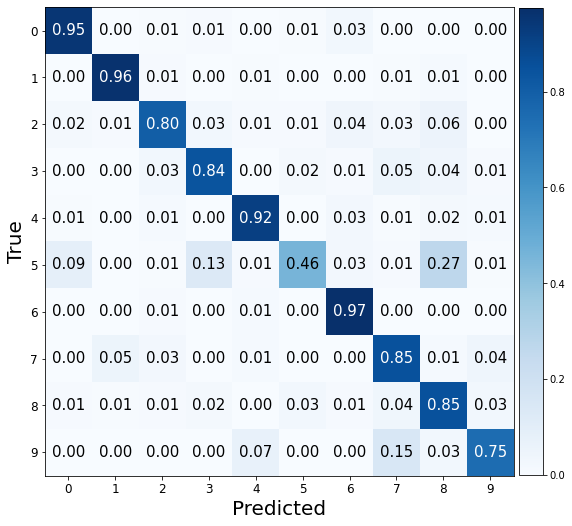



Con 50 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 0.9699487686157227, f1: 0.830370732541901, acc: 0.8355000019073486
*
Esta cargando para 50 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



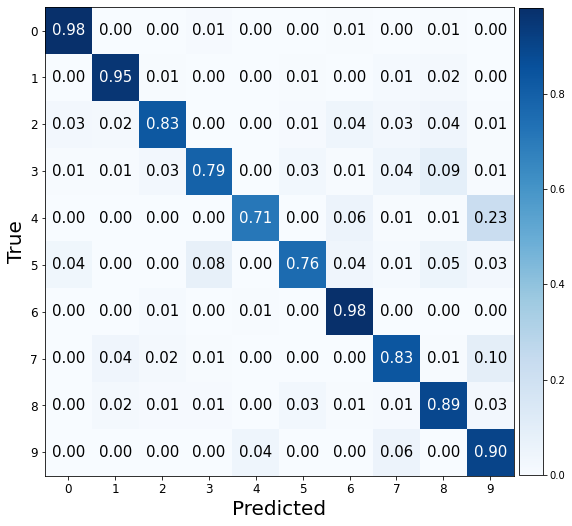



Con 50 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 0.7353034019470215, f1: 0.8617858552198671, acc: 0.862500011920929
*
Esta cargando para 50 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



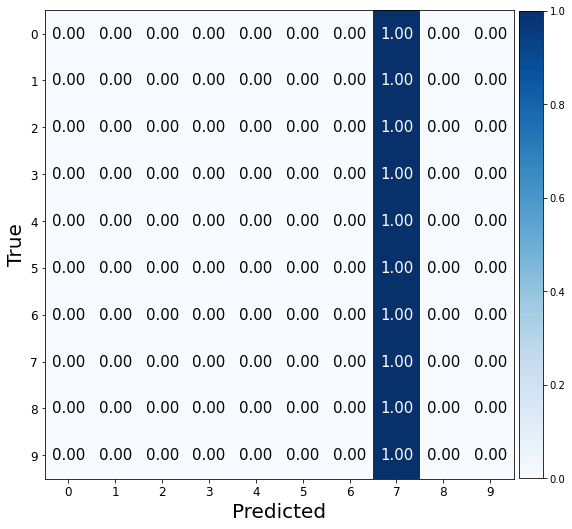



Con 50 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 2.30621075630188, f1: 0.01818181818181818, acc: 0.10000000149011612
*
Esta cargando para 50 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



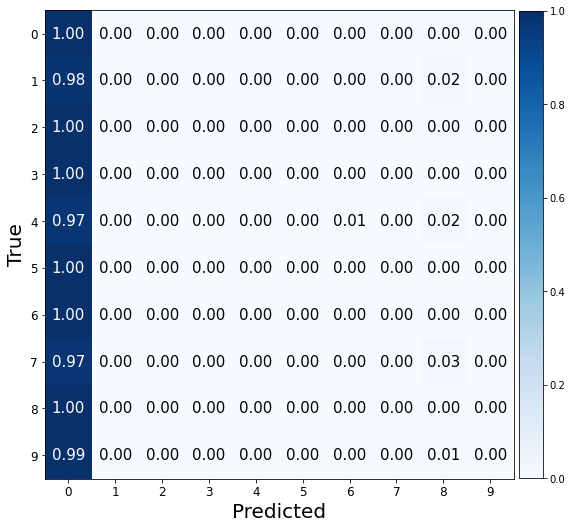



Con 50 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 2.2846081256866455, f1: 0.018306636155606407, acc: 0.10000000149011612
*
Esta cargando para 50 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



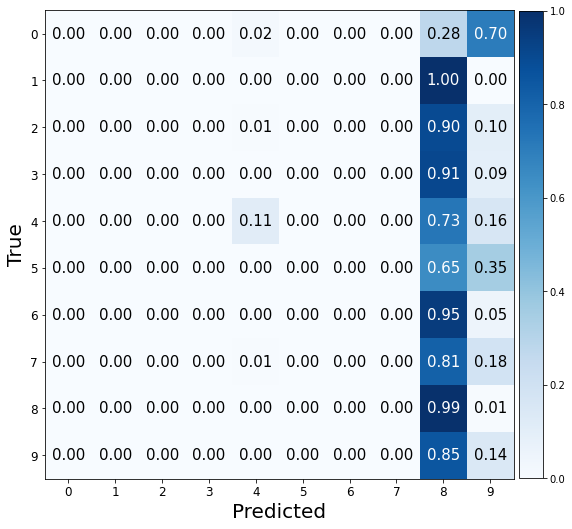



Con 50 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 2.326430320739746, f1: 0.051626481264529865, acc: 0.125
*
Esta cargando para 50 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



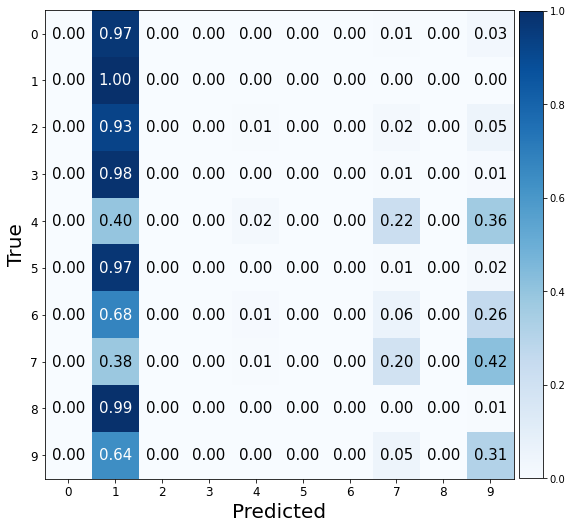



Con 50 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 2.240211009979248, f1: 0.07642077053191802, acc: 0.1525000035762787
*
Esta cargando para 50 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



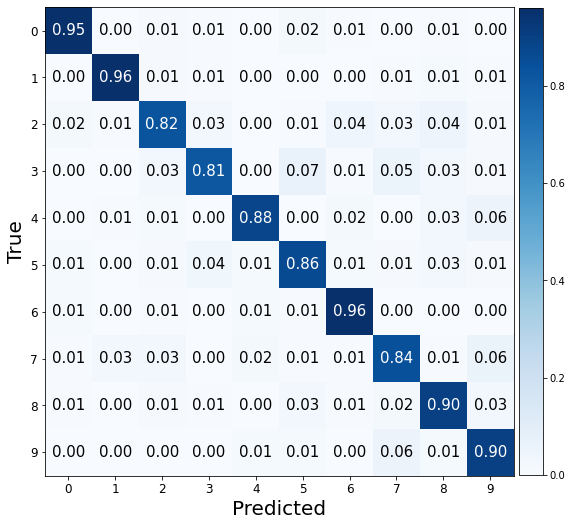



Con 50 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 0.35138434171676636, f1: 0.8892826728732199, acc: 0.8895000219345093
*
Esta cargando para 50 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



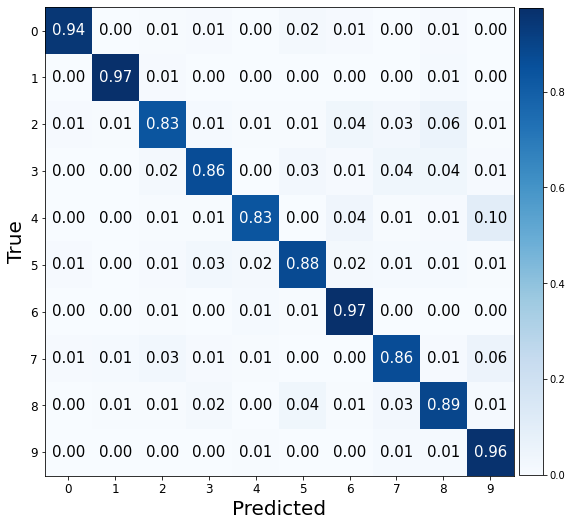



Con 50 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 0.34546715021133423, f1: 0.9022925295738018, acc: 0.9024999737739563
*
Esta cargando para 50 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



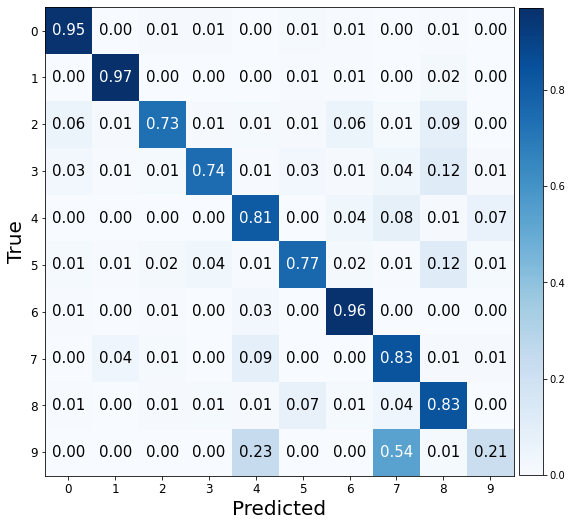



Con 50 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 1.0384918451309204, f1: 0.770400669111077, acc: 0.7825000286102295
*
Esta cargando para 50 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



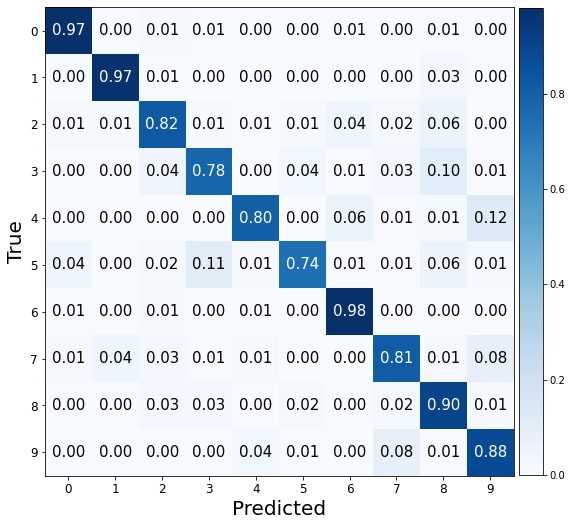



Con 50 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 0.7614644169807434, f1: 0.8640196224576542, acc: 0.8650000095367432
*
Esta cargando para 50 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



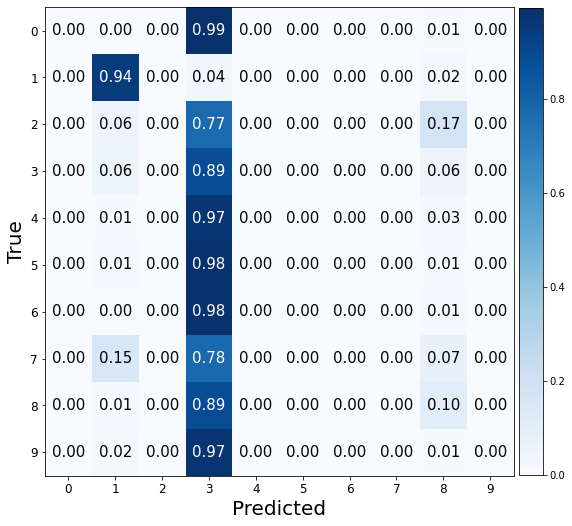



Con 50 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 2.1099767684936523, f1: 0.11693197861559261, acc: 0.19349999725818634
*
Esta cargando para 50 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



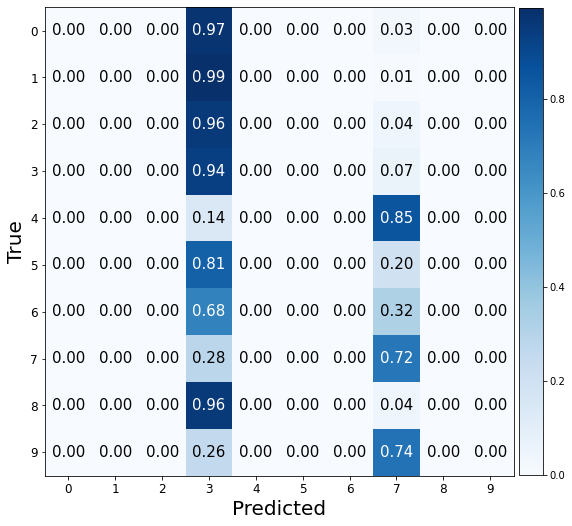



Con 50 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 2.129628896713257, f1: 0.05934467469134501, acc: 0.1655000001192093
*
Esta cargando para 50 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



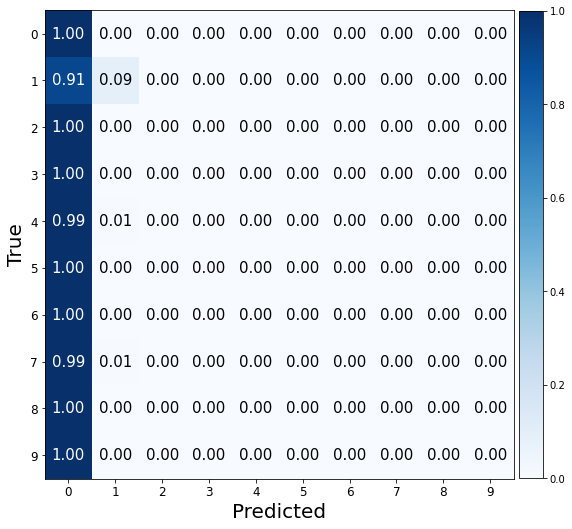



Con 50 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 2.302558660507202, f1: 0.034712260216847375, acc: 0.10899999737739563
*
Esta cargando para 50 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



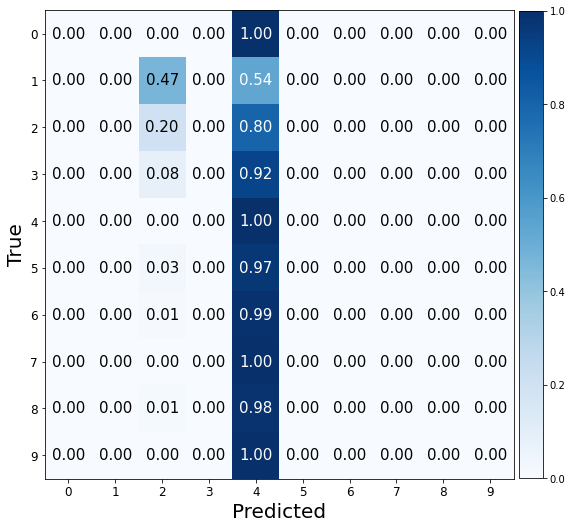



Con 50 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 2.279383897781372, f1: 0.04183006535947713, acc: 0.11999999731779099
*
Esta cargando para 150 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



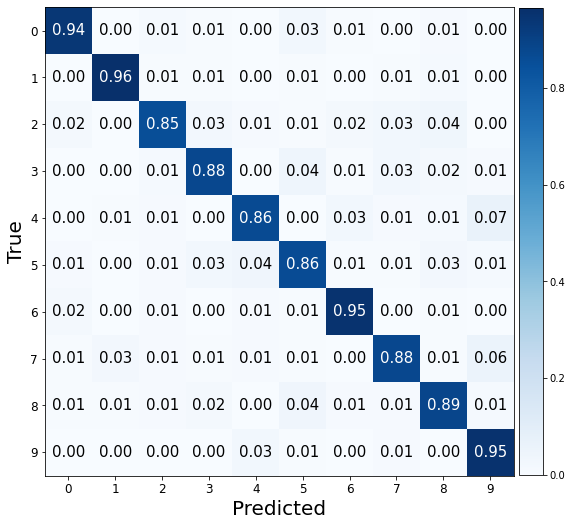



Con 150 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 0.31778520345687866, f1: 0.9018481884979026, acc: 0.9020000100135803
*
Esta cargando para 150 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



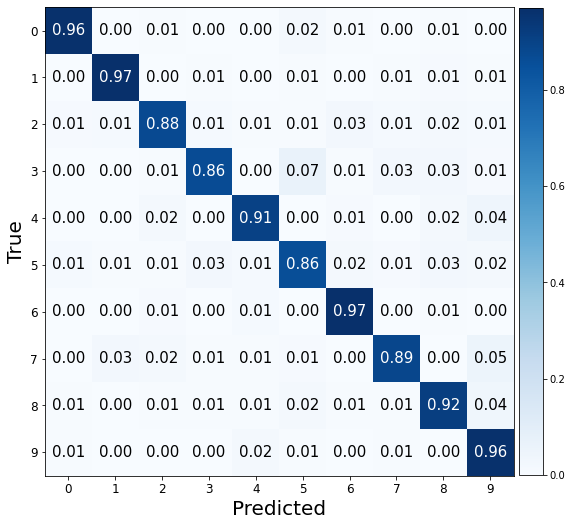



Con 150 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 0.29922792315483093, f1: 0.9173810390833769, acc: 0.9175000190734863
*
Esta cargando para 150 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



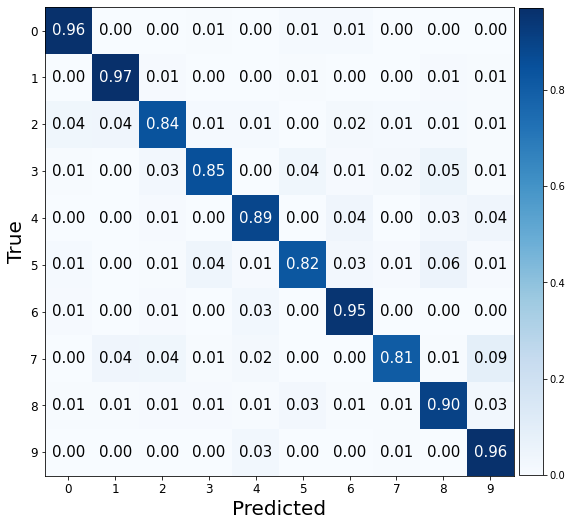



Con 150 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 0.5097253918647766, f1: 0.8947532960672582, acc: 0.8955000042915344
*
Esta cargando para 150 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate.



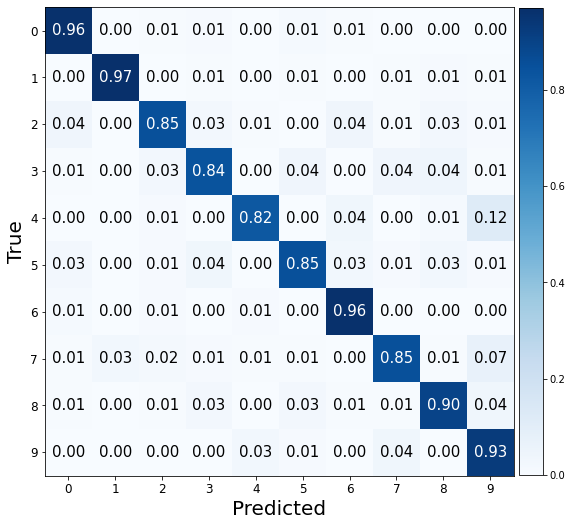



Con 150 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.001 Learning Rate se tiene: loss: 0.47317346930503845, f1: 0.8928038814061086, acc: 0.8930000066757202
*
Esta cargando para 150 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



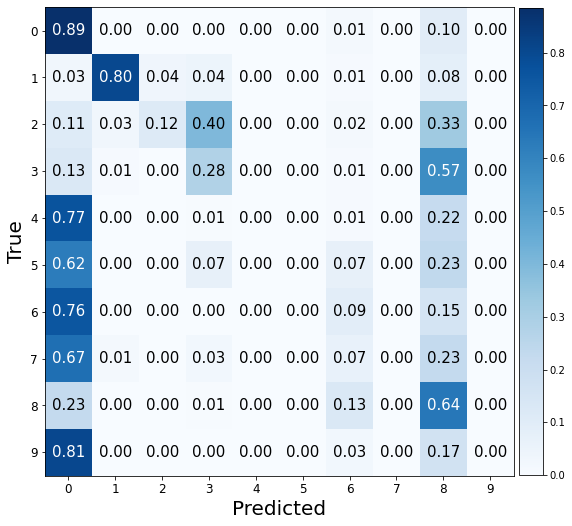



Con 150 epocas, 80 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 1.9066755771636963, f1: 0.21321981172379395, acc: 0.2809999883174896
*
Esta cargando para 150 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



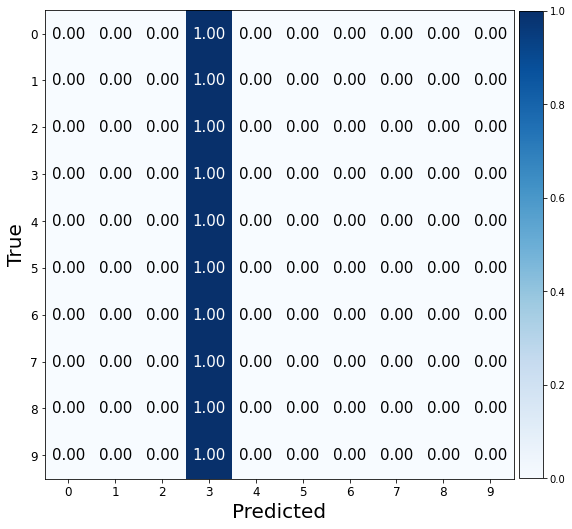



Con 150 epocas, 100 hd, 0.001 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 2.337240695953369, f1: 0.01818181818181818, acc: 0.10000000149011612
*
Esta cargando para 150 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



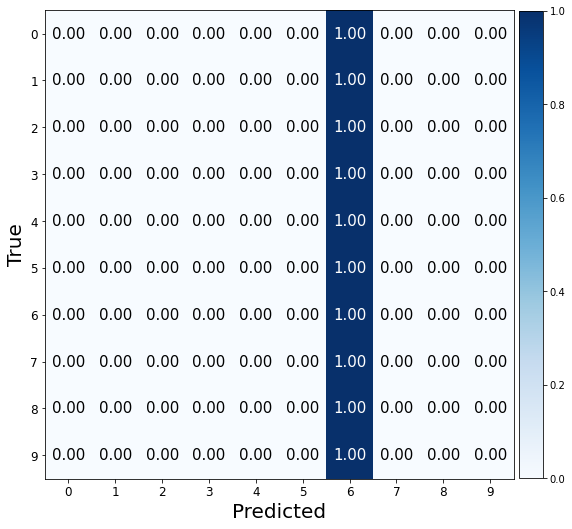



Con 150 epocas, 80 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 2.3025853633880615, f1: 0.01818181818181818, acc: 0.10000000149011612
*
Esta cargando para 150 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate.



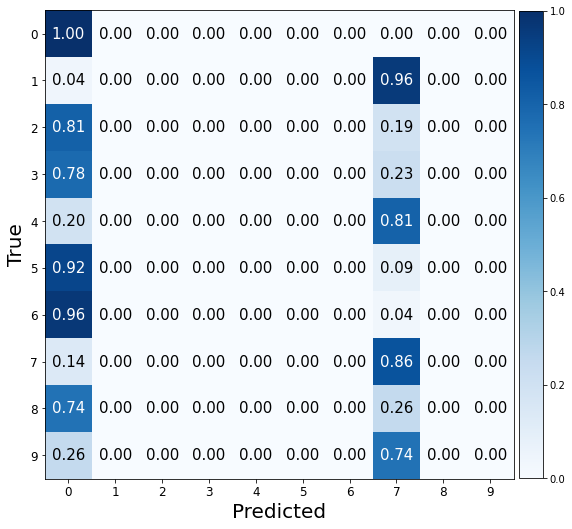



Con 150 epocas, 100 hd, 0.1 Weight Decay, 256 Batch Size y 0.1 Learning Rate se tiene: loss: 2.2277581691741943, f1: 0.06275583151749402, acc: 0.18649999797344208
*
Esta cargando para 150 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



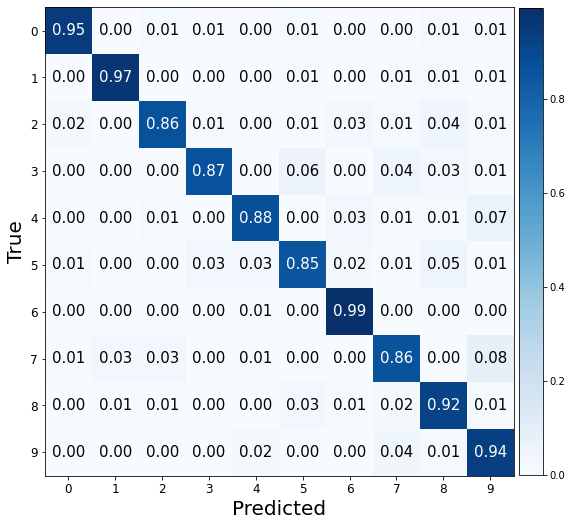



Con 150 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 0.3077421486377716, f1: 0.9095254478198174, acc: 0.909500002861023
*
Esta cargando para 150 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



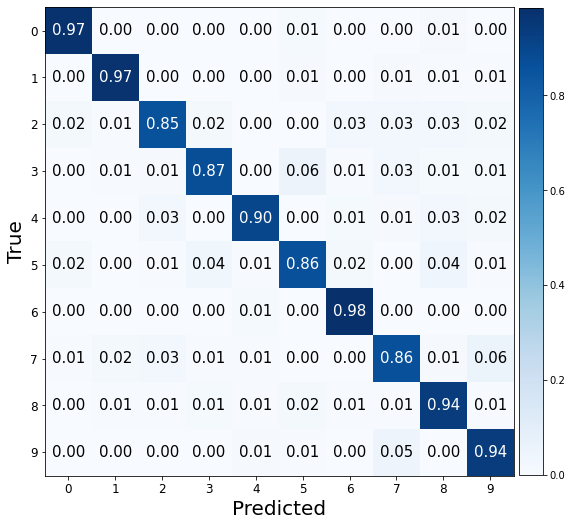



Con 150 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 0.2866697311401367, f1: 0.9151978367345667, acc: 0.9154999852180481
*
Esta cargando para 150 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



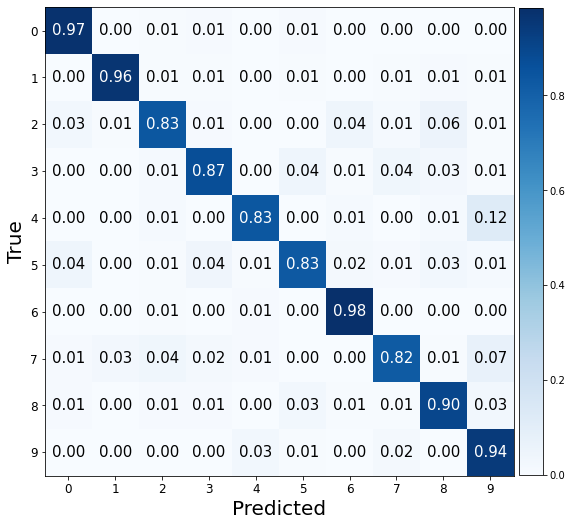



Con 150 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 0.49226826429367065, f1: 0.8955644419192401, acc: 0.8960000276565552
*
Esta cargando para 150 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate.



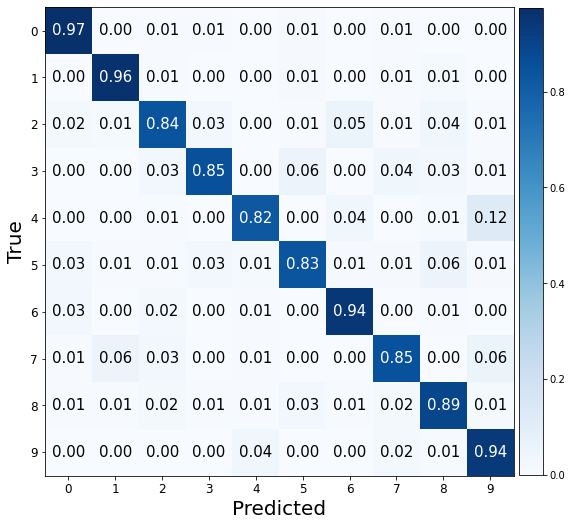



Con 150 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.001 Learning Rate se tiene: loss: 0.48483389616012573, f1: 0.8915267240282814, acc: 0.8920000195503235
*
Esta cargando para 150 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



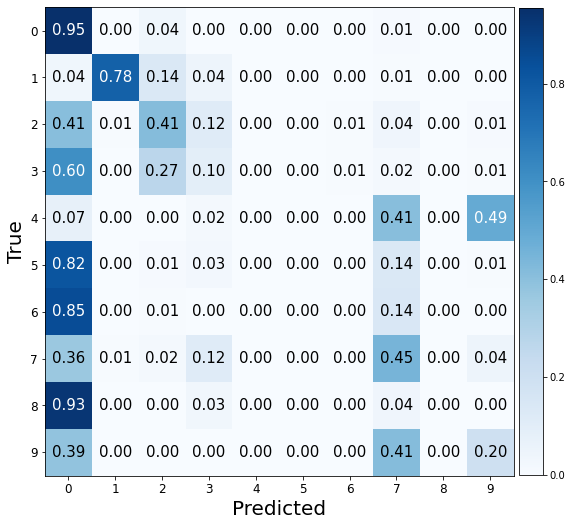



Con 150 epocas, 80 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 1.8107562065124512, f1: 0.2298596377656291, acc: 0.289000004529953
*
Esta cargando para 150 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



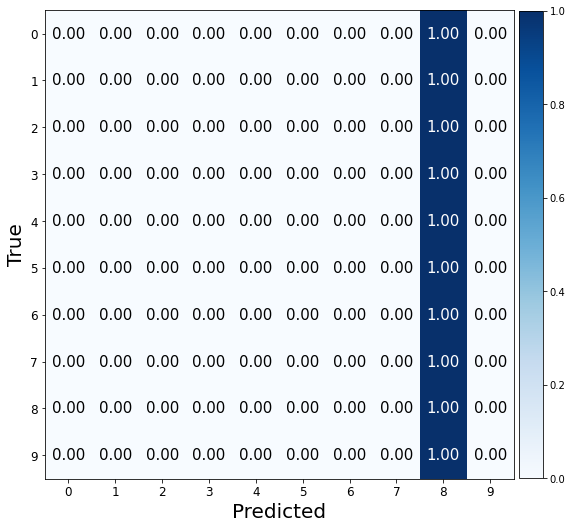



Con 150 epocas, 100 hd, 0.001 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 3.202756404876709, f1: 0.01818181818181818, acc: 0.10000000149011612
*
Esta cargando para 150 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



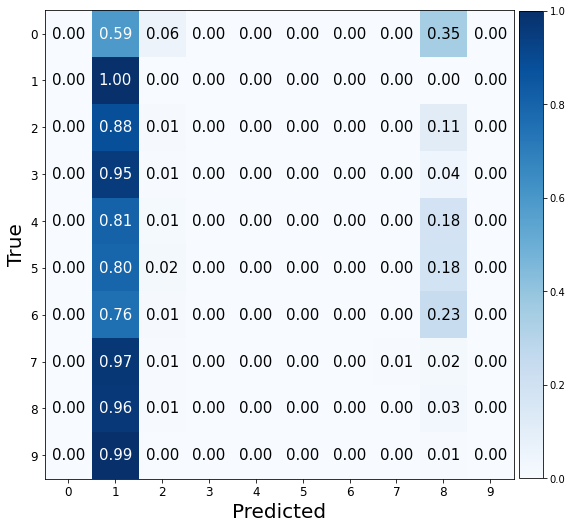



Con 150 epocas, 80 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 2.2761313915252686, f1: 0.026147902779272196, acc: 0.10450000315904617
*
Esta cargando para 150 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate.



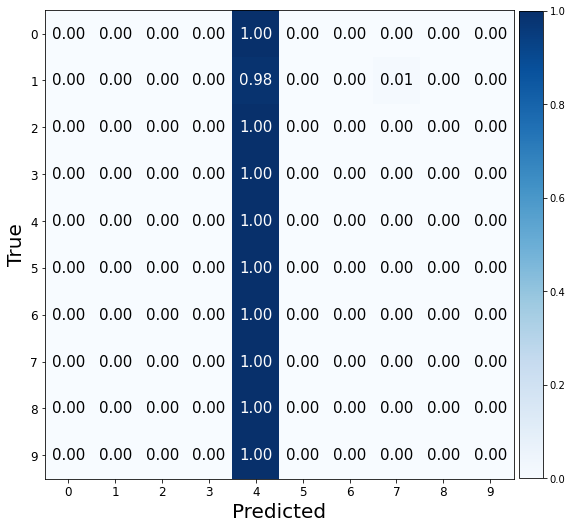



Con 150 epocas, 100 hd, 0.1 Weight Decay, 1024 Batch Size y 0.1 Learning Rate se tiene: loss: 2.261277437210083, f1: 0.018206645425580335, acc: 0.10000000149011612
*
*
*
El orden de menor a mayor de los parametros es:
*
Para la perdida:
{'ne150, hd100, wd0.001, bs1024, lr0.001': {'loss': 0.2866697311401367, 'f1': 0.9151978367345667, 'acc': tensor(0.9155)}, 'ne150, hd100, wd0.001, bs256, lr0.001': {'loss': 0.29922792315483093, 'f1': 0.9173810390833769, 'acc': tensor(0.9175)}, 'ne150, hd80, wd0.001, bs1024, lr0.001': {'loss': 0.3077421486377716, 'f1': 0.9095254478198174, 'acc': tensor(0.9095)}, 'ne150, hd80, wd0.001, bs256, lr0.001': {'loss': 0.31778520345687866, 'f1': 0.9018481884979026, 'acc': tensor(0.9020)}, 'ne50, hd100, wd0.001, bs1024, lr0.001': {'loss': 0.34546715021133423, 'f1': 0.9022925295738018, 'acc': tensor(0.9025)}, 'ne50, hd80, wd0.001, bs1024, lr0.001': {'loss': 0.35138434171676636, 'f1': 0.8892826728732199, 'acc': tensor(0.8895)}, 'ne50, hd100, wd0.001, bs256, lr0.001

[{'loss': ('ne150, hd100, wd0.1, bs1024, lr0.001',
   {'loss': 0.5131293535232544,
    'f1': 0.8915977712492202,
    'acc': tensor(0.8915)}),
  'f1': ('ne150, hd100, wd0.001, bs1024, lr0.001',
   {'loss': 0.6191997528076172,
    'f1': 0.8966204423803849,
    'acc': tensor(0.8970)}),
  'acc': ('ne150, hd100, wd0.001, bs1024, lr0.001',
   {'loss': 0.6191997528076172,
    'f1': 0.8966204423803849,
    'acc': tensor(0.8970)})},
 {'loss': ('ne150, hd100, wd0.001, bs1024, lr0.001',
   {'loss': 0.2866697311401367,
    'f1': 0.9151978367345667,
    'acc': tensor(0.9155)}),
  'f1': ('ne150, hd100, wd0.001, bs256, lr0.001',
   {'loss': 0.29922792315483093,
    'f1': 0.9173810390833769,
    'acc': tensor(0.9175)}),
  'acc': ('ne150, hd100, wd0.001, bs256, lr0.001',
   {'loss': 0.29922792315483093,
    'f1': 0.9173810390833769,
    'acc': tensor(0.9175)})}]

In [5]:
bs_list = [256,1024]
lr_list = [0.001,0.1]
wd_list = [0.001,0.1]
hd_list = [80,100]
ne_list = [50,150]

metodo(ne_list,lr_list,wd_list,bs_list,hd_list)

Los modelos que se utilizan en este trabajo para predecir los números de unas imágenes tienen una capa oculta (modelo 1) y tres capas ocultas (modelo 2). Se estudia el comportamiento de estos modelos para diferentes valores de los metaparámetros que son el Número de épocas, el Learning Rate, el Weight Decay y Batch Size. Como se puede ver en el resultado, en la mayoría de los casos si el valor de perdida es pequeño, el valor de la accuracy y del f1 son altos, esto se debe a que estos modelos están prediciendo de manera correcta el número de la imagen. Sin embargo, esto no ocurre en todos los casos. Como podemos ver los mejores metaparametros para el modelo 1 son ne150, hd100, wd0.001, bs1024, lr0.001 que tienen los mejores valores de accuracy y de f1, y el menor valor de perdida. Además, la matriz que corresponde a estos valores nos muestra que realmente hay una buena predicción de los números en la imágenes. Ya que el porcentaje de los valores que no están en la diagonal es bastante bajo, al rededor del 0.1. 

![mejor_1](mejor_1.png)

Por el otro lado, el que tiene el peor valor de f1, acc y el error más alto es ne150, hd100, wd0.1, bs1024, lr0.1. Si comparamos con los valores del mejor, nos damos cuenta que la única diferencia es en el peso y en la tasa de aprendizaje, por lo que al tener valores tan grandes, como es en este caso, el modelo no alcanza a aprender lo suficiente para poder predecir el valor del número de la imagen. En este caso, en la matriz nos podemos dar cuenta que el modelo cree que todos los número son 2. Lo que noos nuestra que hay un error bastante grande y lo confirmamos con los bajos valores de f1 = 0.022276895356581117 y de acc=0.0955.
![peor_1](peor_1.png)

En el caso del segundo modelo el que tiene los mejores valores es ne150, hd100, wd0.001, bs256, lr0.001 para la accuracy y el f1, seguido de cerca por ne150, hd100, wd0.001, bs1024, lr0.001. En este caso, nos podemos dar cuenta que a pesar de ser modelos distintos, los metaparametros son casi los mismos, exceptuando el valor del batch que como se esperaba debe ser menor al considerar más capas en la red neuronal. Sin embargo, si comparamos los valores del primer modelo y del segundo: 
1ro={'loss': 0.6191997528076172, 'f1': 0.8966204423803849, 'acc': tensor(0.8970)}
2do={'loss': 0.29922792315483093, 'f1': 0.9173810390833769, 'acc': tensor(0.9175)}
Los valores del segundo modelo son mejores que los del primero. Esto conn una menor cantidad del tamaño de batch y con más capas ocultas en la red neuronal.